# Calibrating bias images

The purpose of calibrating bias images is three-fold:

+ Subtract overscan if you have decided your science will be better if you
subtract overscan. See [this discussion of overscan](01-08-Overscan.html) for some guidance.
+ Trim the overscan region off of the image if it is present, regardless of
whether you have chosen to subtract the overscan.
+ Combine the bias images into a "combined" bias to be used in calibrating the
rest of the images. The purpose of combining several images is to reduce as much
as possible the read noise in the combined bias.

The approach in this notebook will be to reduce a single image, look at the
effects the reduction step had on that image and then demonstrate how to
calibrate a folder containing several images of that type.

In [1]:
from pathlib import Path
import os

from astropy.nddata import CCDData
from astropy.visualization import hist
import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np

from convenience_functions import show_image

In [2]:
# Use custom style for larger fonts and figures
plt.style.use('guide.mplstyle')

### Data for these examples

See the [Preface notebook](00-00-Preface.html) for download links for all data.

## Example 1: With overscan subtraction

### Decide where to put your Example 1 calibrated images

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/107/files#diff-7160ef18a737dfb1b8282fbbbcb37d9cR82){:target="_blank"}
Though it is possible to overwrite your raw data with calibrated images that is
a bad idea. Here we create a folder called `example1-reduced` that will contain
the calibrated data and create it if it doesn't exist.

In [3]:
calibrated_data = Path('.', 'example1-reduced')
calibrated_data.mkdir(exist_ok=True)

### Make an image file collection for the raw data

In [4]:
example_cryo_path = Path('example-cryo-LFC')
files = ccdp.ImageFileCollection(example_cryo_path)

In [5]:
files.summary['file', 'imagetyp', 'filter', 'exptime', 'naxis1', 'naxis2']

file,imagetyp,filter,exptime,naxis1,naxis2
str14,str9,str2,float64,int64,int64
ccd.001.0.fits,BIAS,i',0.0,2080,4128
ccd.002.0.fits,BIAS,i',0.0,2080,4128
ccd.003.0.fits,BIAS,i',0.0,2080,4128
ccd.004.0.fits,BIAS,i',0.0,2080,4128
ccd.005.0.fits,BIAS,i',0.0,2080,4128
ccd.006.0.fits,BIAS,i',0.0,2080,4128
ccd.014.0.fits,FLATFIELD,g',70.001,2080,4128
ccd.015.0.fits,FLATFIELD,g',70.011,2080,4128
ccd.016.0.fits,FLATFIELD,g',70.001,2080,4128


In [6]:
darks_only = ccdp.ImageFileCollection(example_cryo_path / 'darks')
darks_only.summary['file', 'imagetyp', 'exptime']

file,imagetyp,exptime
str14,str4,float64
ccd.002.0.fits,BIAS,0.0
ccd.013.0.fits,DARK,300.0
ccd.014.0.fits,DARK,300.0
ccd.015.0.fits,DARK,300.0
ccd.017.0.fits,DARK,70.0
ccd.018.0.fits,DARK,70.0
ccd.019.0.fits,DARK,70.0
ccd.023.0.fits,DARK,7.0
ccd.024.0.fits,DARK,7.0


### Determine overscan region for the LFC Chip 0

Please see the discussion of this camera in
[the overscan notebook](01.08-Overscan.ipynb#Case-1:-Cryogenically-cooled-Large-Format-Camera-(LFC)-at-Palomar) for the appropriate overscan region
to use for this camera. Note, in particular, that it differs from the the value
given in the `BIASSEC` keyword in the header of the images.

The astropy affiliated package [ccdproc](https://ccdproc.readthedocs.io) provides two
useful functions here:

+ `subtract_overscan` for subtracting the overscan from the image, and
+ `trim_image` for trimming off the overscan.

First, let's see what the values of `BIASSEC` which sometimes (but not always)
indicates that there is is overscan and which part of the chip is the overscan,
and `CCDSEC`, which is sometimes, but not always present, and indicates which
part of the chip light hit.

Note that neither of these are standard; sometimes, for example, `trimsec` is
used instead of `ccdsec`, and there are likely other variants. Some images may
have neither keyword in the header. That does not necessary indicate that
ovserscan isn't present. The best advice is to carefully check the documentation
for the camera you are using.

In [7]:
files.summary['file', 'imagetyp', 'biassec', 'ccdsec', 'datasec'][0]

file,imagetyp,biassec,ccdsec,datasec
str14,str9,str18,str15,str15
ccd.001.0.fits,BIAS,"[2049:2080,1:4127]","[1:2048,1:4128]","[1:2048,1:4128]"


The fits header claims the overscan extends from the 2049$^{th}$ column to the
end of the image (this is one-based indexing) and that the part of the image
exposed to light extends over all rows and from the first column to the
2048$^{th}$ column (again, this is one-indexed).

### FITS *vs* Python indexing

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/107/files#diff-7160ef18a737dfb1b8282fbbbcb37d9cR196){:target="_blank"}

There are two differences between FITS and Python in terms of indexing:

+ Python indexes are zero-based (i.e. numbering starts at zero), FITS indexes
are one-based (i.e. numbering starts at 1).
+ The *order* of the indexes is swapped.

For example, the **FITS** representation of the part of the chip exposed to
light is `[1:2048,1:4128]`. To access that part of the data from a numpy array
in **Python**, switch the order so that the indexing looks like this: `[0:4128,
0:2048]` (or, more compactly `[:, :2048]`). Note that the *ending* indexes given
here for python are correct because the second part of a range (after the colon)
is *not included* in the array slice. For example, `0:2048` starts at 0 (the
first pixel) and goes up to but not including 2048, so the last pixel included
is `2047` (the 2048$^{th}$ pixel).

As discussed in [the overscan notebook](01.08-Overscan.ipynb#Case-1:-Cryogenically-cooled-Large-Format-Camera-(LFC)-at-Palomar), the useful
overscan region for this camera starts at the 2055$^{th}$ column, not column
2049 as indicated by the `BIASSEC` keyword in the header. This situation is not
unusual; column 2049 is the first of the columns masked by the manufacturer from
light but there is some leakage into this region from the rest of the CCD.

If you are going to overscan you need to carefully examine the overscan in a few
representative images to understand which part of the overscan to use.

In what follows, we will use for the overscan the region (Python/numpy indexing)
`[:, 2055:]`.

### Subtract and then trim the overscan (one sample image)

Using `subtract_overscan` is reasonably straightforward, as shown in the cell
below.

In [8]:
raw_biases = files.files_filtered(include_path=True, imagetyp='BIAS')

In [9]:
first_bias = CCDData.read(raw_biases[0], unit='adu')

In [10]:
bias_overscan_subtracted = ccdp.subtract_overscan(first_bias, overscan=first_bias[:, 2055:], median=True)

Next, we trim off the full overscan region (not just the part we used for
subtracting overscan)

In [11]:
trimmed_bias = ccdp.trim_image(bias_overscan_subtracted[:, :2048])

Text(0.5, 1.0, 'Bias, overscan subtracted and trimmed')

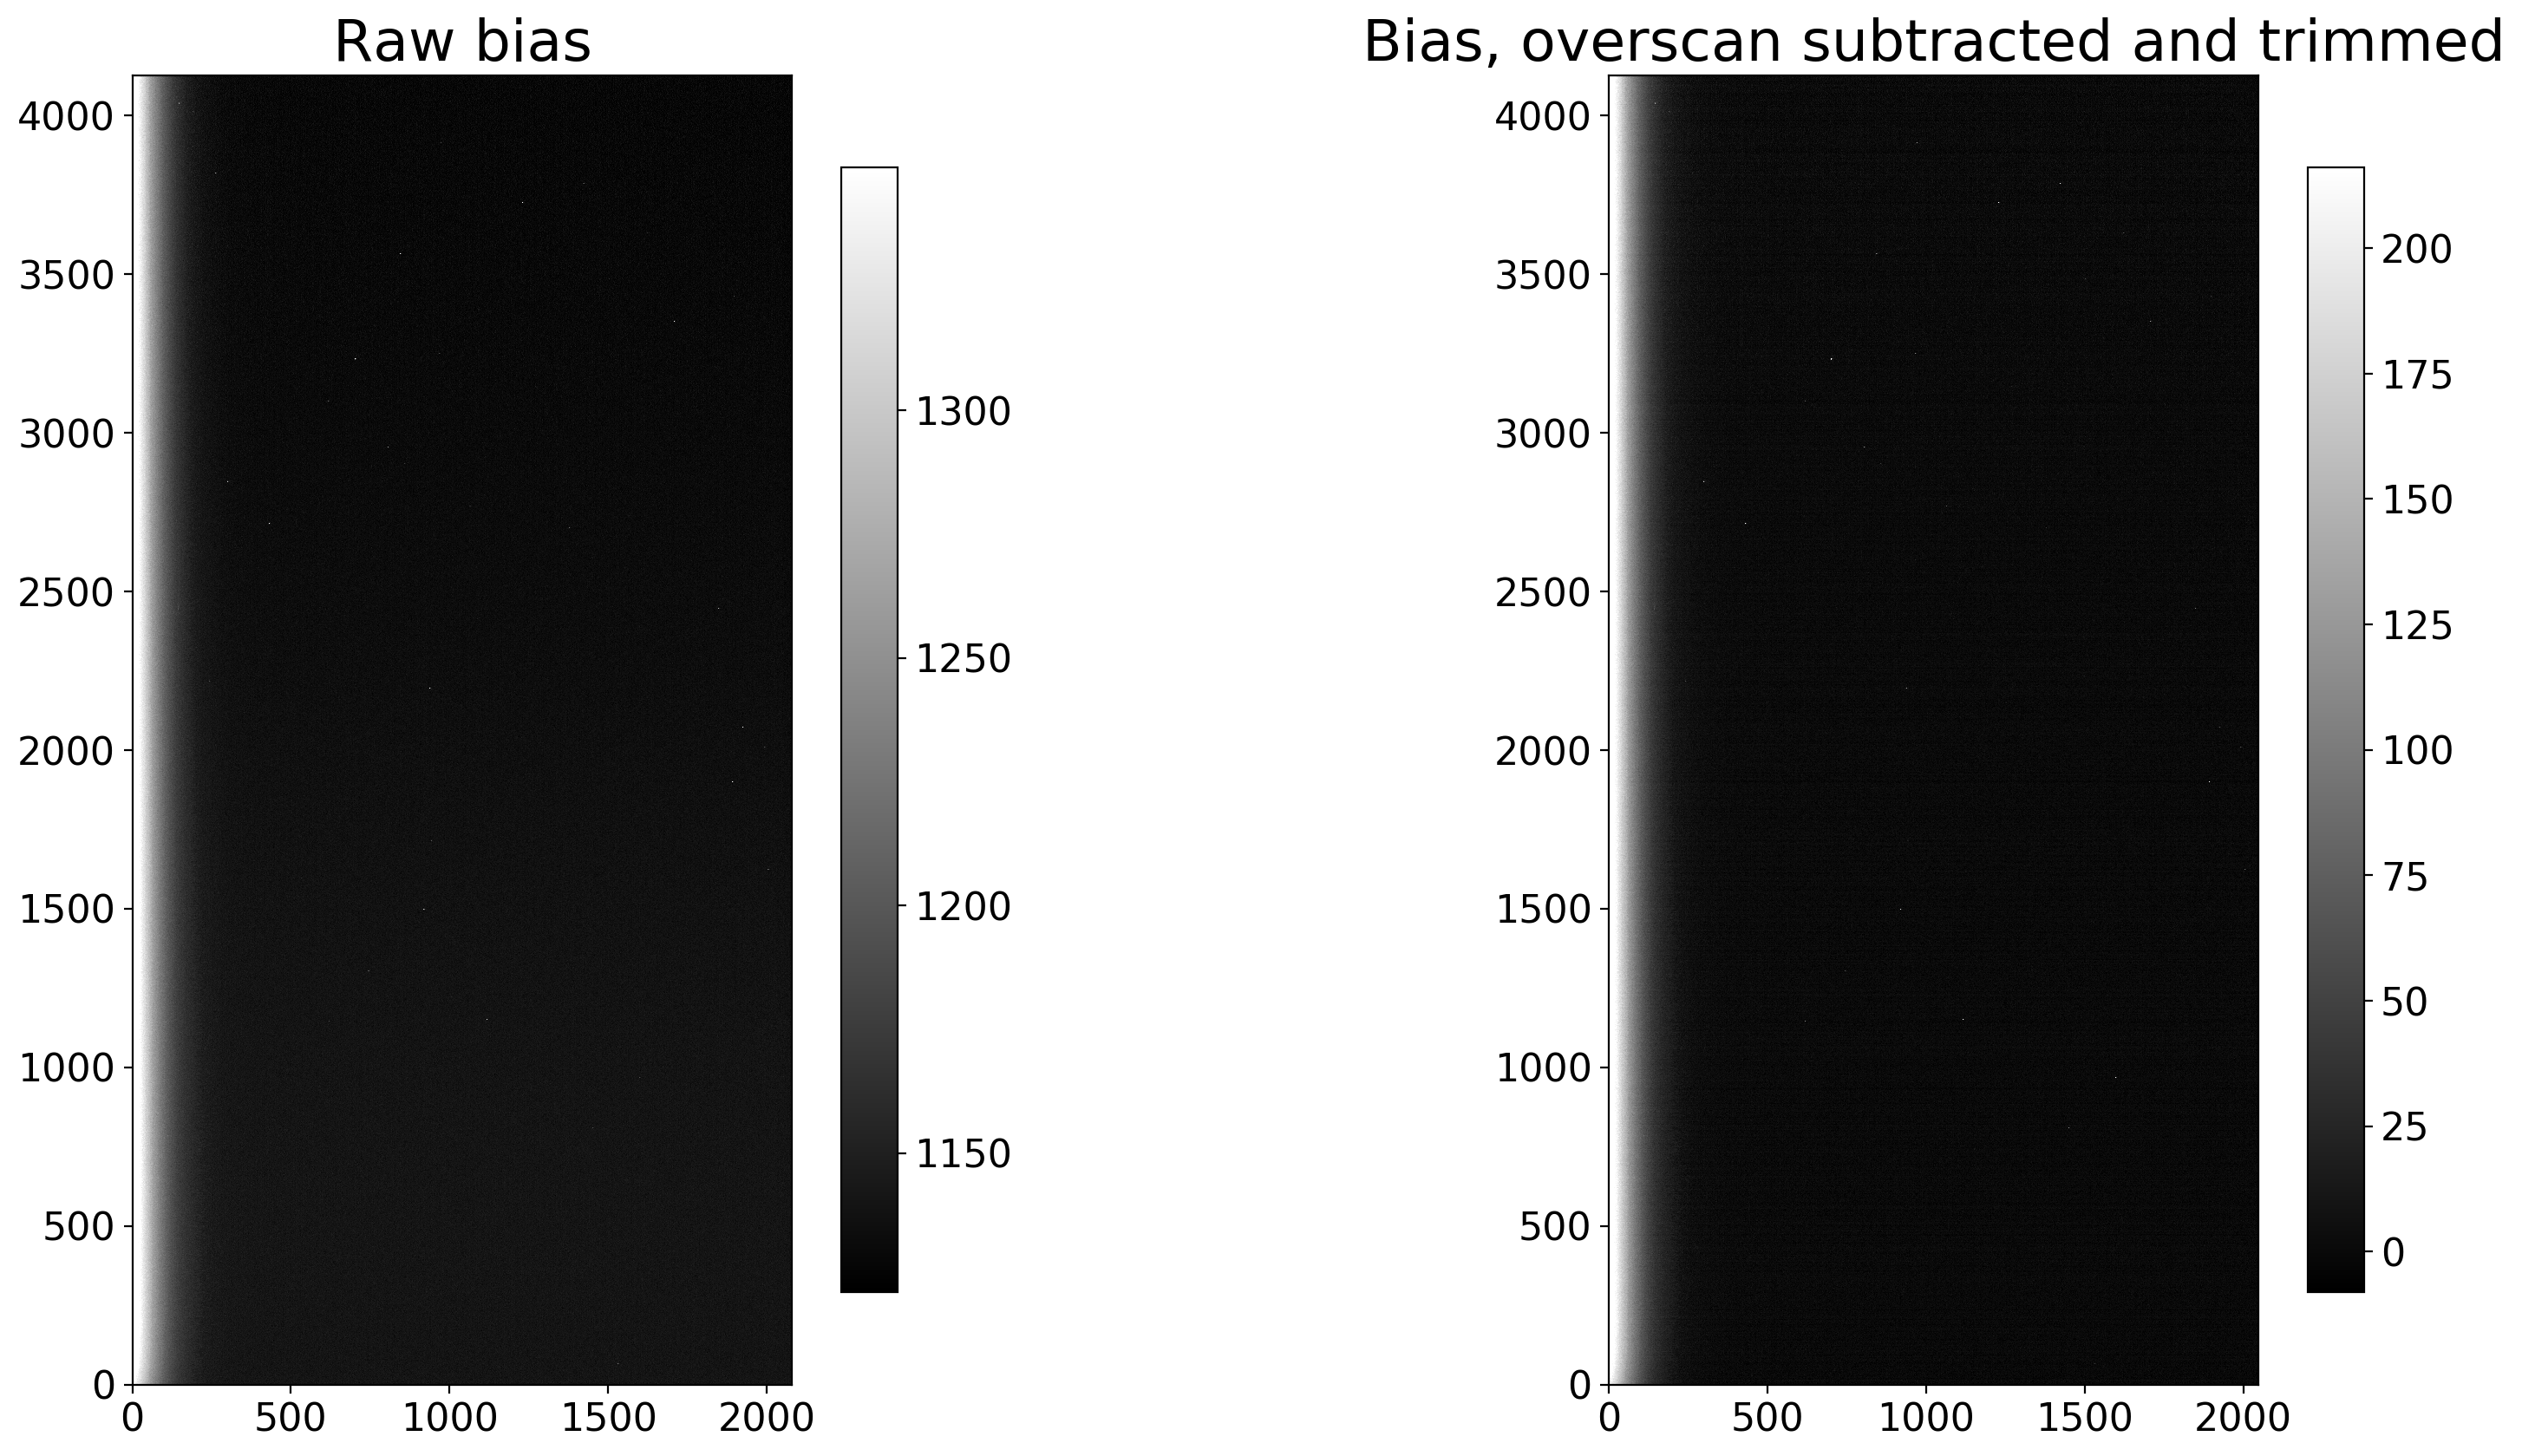

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

show_image(first_bias.data, cmap='gray', ax=ax1, fig=fig)
ax1.set_title('Raw bias')
show_image(trimmed_bias.data, cmap='gray', ax=ax2, fig=fig)
ax2.set_title('Bias, overscan subtracted and trimmed')

### Discussion

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/107/files#diff-7160ef18a737dfb1b8282fbbbcb37d9cR308){:target="_blank"}

Visually, the images look nearly identical before and after calibration. The
only prominent difference is a shift in the pixel values, as one would expect
from subtracting the same value from each pixel in an image. It simply shifts
the zero point.

There is ones other important difference between the images: the input image
uses 32MB of memory while the calibrated, overscan-subtracted image uses roughly
128MB. The input image is stored as unsigned 16-bit integers; the calibrated
image is stored as floating point numbers, which default in python to 64-bit
floats. The memory size is also the size the files will have when written to
disk (ignoring any compression). One can reduce the memory and disk footprint by
changing the `dtype` of the image: `trimmed_bias.dtype = 'float32'`. It is best
to do this just before writing the image out because arithmetic operations on
the image may convert its dtype back to `float64`.



### Processing the folder of bias images for the LFC Chip 0

Processing each of the bias images individually would be tedious, at best.
Instead, we can use the [`ImageFileCollection`](https://ccdproc.readthedocs.io/en/latest/ccdproc/image_management.html) we created above to
loop over only the bias images, saving each in the folder `calibrated_data`. In
this example the files are saved uncompressed because the Python library for
compressing gzip files is extremely slow.

In [13]:
for ccd, file_name in files.ccds(imagetyp='BIAS',            # Just get the bias frames
                                 ccd_kwargs={'unit': 'adu'}, # CCDData requires a unit for the image if 
                                                             # it is not in the header
                                 return_fname=True           # Provide the file name too.
                                ):
        # Subtract the overscan
    ccd = ccdp.subtract_overscan(ccd, overscan=ccd[:, 2055:], median=True)
    
    # Trim the overscan
    ccd = ccdp.trim_image(ccd[:, :2048])
    
    # Save the result
    ccd.write(calibrated_data / file_name)

Let's check that we really did get the images we expect by creating an
[`ImageFileCollection`](https://ccdproc.readthedocs.io/en/latest/ccdproc/image_management.html) for the reduced folder and displaying the size
of each image. We are expecting the images to be 2048 × 4128, and that there
will be the same number of reduced bias images as input bias images (six).

In [14]:
reduced_images = ccdp.ImageFileCollection(calibrated_data)
reduced_images.summary['file', 'imagetyp', 'naxis1', 'naxis2']

file,imagetyp,naxis1,naxis2
str14,str4,int64,int64
ccd.001.0.fits,BIAS,2048,4128
ccd.002.0.fits,BIAS,2048,4128
ccd.003.0.fits,BIAS,2048,4128
ccd.004.0.fits,BIAS,2048,4128
ccd.005.0.fits,BIAS,2048,4128
ccd.006.0.fits,BIAS,2048,4128


## Example 2: No overscan subtraction, but trim the images

If you are not subtracting overscan then the only manipulation you may need to
do is trimming the overscan from the images. If there is no overscan region in
your images then even that is unnecessary.

### Decide where to put your calibrated Example 2 images

Though it is possible to overwrite your raw data with calibrated images that is
a bad idea. Here we create a folder called `example2-reduced` that will contain
the calibrated data and create it if it doesn't exist.

In [15]:
calibrated_data = Path('.', 'example2-reduced')
calibrated_data.mkdir(exist_ok=True)

In [16]:
files = ccdp.ImageFileCollection('example-thermo-electric')
files.summary['file', 'imagetyp', 'filter', 'exptime', 'naxis1', 'naxis2']

file,imagetyp,filter,exptime,naxis1,naxis2
str35,str5,object,float64,int64,int64
AutoFlat-PANoRot-r-Bin1-001.fit,FLAT,r,1.0,4109,4096
AutoFlat-PANoRot-r-Bin1-002.fit,FLAT,r,1.0,4109,4096
AutoFlat-PANoRot-r-Bin1-003.fit,FLAT,r,1.0,4109,4096
AutoFlat-PANoRot-r-Bin1-004.fit,FLAT,r,1.0,4109,4096
AutoFlat-PANoRot-r-Bin1-005.fit,FLAT,r,1.0,4109,4096
AutoFlat-PANoRot-r-Bin1-006.fit,FLAT,r,1.02,4109,4096
AutoFlat-PANoRot-r-Bin1-007.fit,FLAT,r,1.06,4109,4096
AutoFlat-PANoRot-r-Bin1-008.fit,FLAT,r,1.11,4109,4096
AutoFlat-PANoRot-r-Bin1-009.fit,FLAT,r,1.16,4109,4096


### Determine overscan region for this camera

Please see the discussion of this camera in [the overscan notebook](01.08-Overscan.ipynb#Case-2:-Thermo-electrically-cooled-Apogee-Aspen-CG16M) for
a discussion of the overscan region of this camera. The overscan for this camera
is not useful but should be trimmed out at this stage.

These headers have some information in the keywords `BIASSEC` and `TRIMSEC`
indicating, in the FITS numbering convention, the overscan region and the
science region of the chip.

In [17]:
files.summary['file', 'imagetyp', 'biassec', 'trimsec'][0]

file,imagetyp,biassec,trimsec
str35,str5,str11,str11
AutoFlat-PANoRot-r-Bin1-001.fit,FLAT,[4096:4109],"[1:4096, :]"


Based on this, and the decision not to subtract overscan for this camera, we
will only need to trim the overscan region off of the images. See the discussion
at [FITS *vs* Python indexing](#FITS-vs-Python-indexing), above, for some details about the
difference between FITS and Python indexing. Essentially, to get Python indexes
from FITS, reverse the order and subtract one.

### Trim the overscan (one sample image)

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/107/files#diff-7160ef18a737dfb1b8282fbbbcb37d9cR482){:target="_blank"}

The function `trim_image` from [ccdproc](ccdproc.rtfd.io) removes a
portion of the image and updates the image metadata as needed.

Below we get the first bias image.

In [18]:
raw_biases = files.files_filtered(include_path=True, imagetyp='BIAS')

first_bias = CCDData.read(raw_biases[0], unit='adu')

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


There two ways of specifying the region to trim. One is to slice the image in
Python; the other is to use the `fits_section` argument to `trim_image`.

The cell below uses a FITS-style section.

In [19]:
trimmed_bias_fits = ccdp.trim_image(first_bias, fits_section='[1:4096, :]')

The cell below does the same trimming as the one above, but with Python-style
slicing.

In [20]:
trimmed_bias_python = ccdp.trim_image(first_bias[:, :4096])

In [21]:
np.testing.assert_allclose(trimmed_bias_python, trimmed_bias_fits)

### Processing the folder of bias images for Example 2

As in [Example 1](#Example-1:-With-overscan-subtraction), above, we can use the
[`ImageFileCollection`](https://ccdproc.readthedocs.io/en/latest/ccdproc/image_management.html) we created  to loop over only the bias images,
saving each in the folder `calibrated_data`.

In [22]:
for ccd, file_name in files.ccds(imagetyp='BIAS',            # Just get the bias frames
                                 return_fname=True           # Provide the file name too.
                                ):    
    # Trim the overscan
    ccd = ccdp.trim_image(ccd[:, :4096])
    
    # Save the result
    ccd.write(calibrated_data / file_name)

## Example 3: No overscan at all

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/107/files#diff-7160ef18a737dfb1b8282fbbbcb37d9cR582){:target="_blank"}

If there is no overscan then there is, in principle, nothing to be done with the
bias frames. It may be convenient to copy them to the directory with the rest of
your reduced images. The code below does that.

In [23]:
calibrated_data = Path('.', 'example3-reduced')
calibrated_data.mkdir(exist_ok=True)

biases = files.files_filtered(imagetyp='BIAS', include_path=True)

import shutil

for bias in biases:
    shutil.copy(bias, calibrated_data)